In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import requests
import matplotlib.dates as mdates
%matplotlib inline

import datetime as dt
import mplfinance as mpf

import time

import os
from os import listdir
from os.path import isfile, join

import statsmodels.api as sm
import seaborn as sns

from statsmodels.tsa.ar_model import AutoReg, ar_select_order

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

from itertools import combinations


In [2]:
start_date = "2013-01-02"
today = dt.datetime.today().strftime("%Y-%m-%d")
print("Start date: ",start_date)
print("Today's date: ", today)

Start date:  2013-01-02
Today's date:  2023-08-15


In [38]:
PATH = "C:/Users/dietd/Untitled Folder/Portfolio Optimization/Stock Data/"
risk_free_rate = 0.015

In [14]:
#save stocks to csv
def save_to_csv_from_yahoo(ticker, startdate, enddate):
    start = startdate
    end = enddate

    try:
        print("Get Data for :", ticker)
        df = yf.download(ticker, start=start, end=end)['Adj Close']
        time.sleep(0)
        df.to_csv(PATH + ticker + '.csv')

    except Exception as ex:
        stocks_not_downloaded.append(ticker)
        print("Could not download data for: "+ticker)

#function that returns df from csv
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + '.csv', index_col='Date', parse_dates=True)

    except FileNotFoundError:
        print("File Does Not Exist")
        pass

    else:
        return df

In [40]:
own_tickers = ["META", "AAPL", "NFLX", "TSLA", "AMZN", "GOOG", "AMD", "INTC", "NVDA", "GNRC", "DXCM", "COST", "TGT", "AES", "MSCI", "NEM", "AMT", "HES",
                "^GSPC", "VWRL.AS", "QTUM"]

max_assets = 20

asset_combinations = list(combinations(own_tickers, max_assets))

print(len(asset_combinations))


21


In [16]:
#download data
for x in own_tickers:
    save_to_csv_from_yahoo(x, start_date,today)

Get Data for : META
[*********************100%***********************]  1 of 1 completed
Get Data for : AAPL
[*********************100%***********************]  1 of 1 completed
Get Data for : NFLX
[*********************100%***********************]  1 of 1 completed
Get Data for : TSLA
[*********************100%***********************]  1 of 1 completed
Get Data for : AMZN
[*********************100%***********************]  1 of 1 completed
Get Data for : GOOG
[*********************100%***********************]  1 of 1 completed
Get Data for : AMD
[*********************100%***********************]  1 of 1 completed
Get Data for : INTC
[*********************100%***********************]  1 of 1 completed
Get Data for : NVDA
[*********************100%***********************]  1 of 1 completed
Get Data for : GNRC
[*********************100%***********************]  1 of 1 completed
Get Data for : DXCM
[*********************100%***********************]  1 of 1 completed
Get Data for : COST
[*

In [17]:
#merge multiple stock in one df by column name
def merge_df_by_column_name(col_name, sdate, edate, *tick_args):
    mult_df = pd.DataFrame()
    #print(tick_args[0])
    for x in tick_args:
        #print(x)
        df = get_df_from_csv(x)
        #df['Date']=pd.to_datetime(df['Date'])
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
    
    return mult_df

In [20]:
main_df = merge_df_by_column_name('Adj Close', start_date, today, *own_tickers)
main_df

,META,AAPL,NFLX,TSLA,AMZN,GOOG,AMD,INTC,NVDA,GNRC,...,COST,TGT,AES,MSCI,NEM,AMT,HES,^GSPC,VWRL.AS,QTUM
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,28.000000,16.791185,13.144286,2.357333,12.865500,18.013729,2.530000,15.545013,2.936478,30.899977,...,83.025909,44.051067,7.968691,29.110884,37.159370,64.169914,45.358669,1462.420044,57.429798,NaN
2013-01-03,27.770000,16.579243,13.798571,2.318000,12.924000,18.024191,2.490000,15.501387,2.938786,30.399609,...,83.877045,45.054623,7.925225,28.965918,36.145199,62.603222,45.772461,1459.369995,57.361099,NaN
2013-01-04,28.760000,16.117432,13.711429,2.293333,12.957500,18.380356,2.590000,15.385049,3.035746,30.469833,...,83.606987,45.369164,8.113576,28.857203,36.398758,62.546402,46.464966,1466.469971,57.520599,NaN
2013-01-07,29.420000,16.022633,14.171429,2.289333,13.423000,18.300158,2.670000,15.450489,2.948022,30.434719,...,82.960442,45.908371,7.860029,28.875313,35.661903,62.473358,47.157459,1461.890015,57.390598,NaN
2013-01-08,29.059999,16.065744,13.880000,2.245333,13.319000,18.264042,2.670000,15.334158,2.883381,30.408384,...,82.804924,45.414104,7.860029,28.802830,36.097675,62.724991,46.794323,1457.150024,57.187302,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-08,312.640015,179.557526,438.299988,249.699997,139.940002,131.839996,113.230003,35.020000,446.640015,108.339996,...,556.119995,130.979996,19.620001,546.685303,39.840000,184.610001,153.410004,4499.379883,102.660004,50.369999
2023-08-09,305.209991,177.949707,428.899994,242.190002,137.850006,130.149994,110.470001,34.279999,425.540009,106.750000,...,559.700012,130.600006,19.610001,544.820007,39.910000,187.100006,156.399994,4467.709961,102.620003,49.759998
2023-08-10,305.739990,177.729996,429.980011,245.339996,138.559998,130.210007,110.230003,34.680000,423.880005,108.660004,...,561.489990,130.919998,19.610001,546.859985,39.840000,186.940002,156.570007,4468.830078,103.080002,49.529999


In [22]:
list_of_dataframes = []

for l in asset_combinations:
    df = pd.DataFrame(columns=l)
    for ticker in l:
        df[ticker]=main_df[ticker]

    df = df.set_index(main_df.index)
    list_of_dataframes.append(df)

In [41]:
list_of_dataframes, len(list_of_dataframes)

([                  META        AAPL        NFLX        TSLA        AMZN  \
  Date                                                                     
  2013-01-02   28.000000   16.791185   13.144286    2.357333   12.865500   
  2013-01-03   27.770000   16.579243   13.798571    2.318000   12.924000   
  2013-01-04   28.760000   16.117432   13.711429    2.293333   12.957500   
  2013-01-07   29.420000   16.022633   14.171429    2.289333   13.423000   
  2013-01-08   29.059999   16.065744   13.880000    2.245333   13.319000   
  ...                ...         ...         ...         ...         ...   
  2023-08-08  312.640015  179.557526  438.299988  249.699997  139.940002   
  2023-08-09  305.209991  177.949707  428.899994  242.190002  137.850006   
  2023-08-10  305.739990  177.729996  429.980011  245.339996  138.559998   
  2023-08-11  301.640015  177.789993  421.660004  242.649994  138.410004   
  2023-08-14  306.190002  179.460007  427.779999  239.759995  140.570007   
  
         

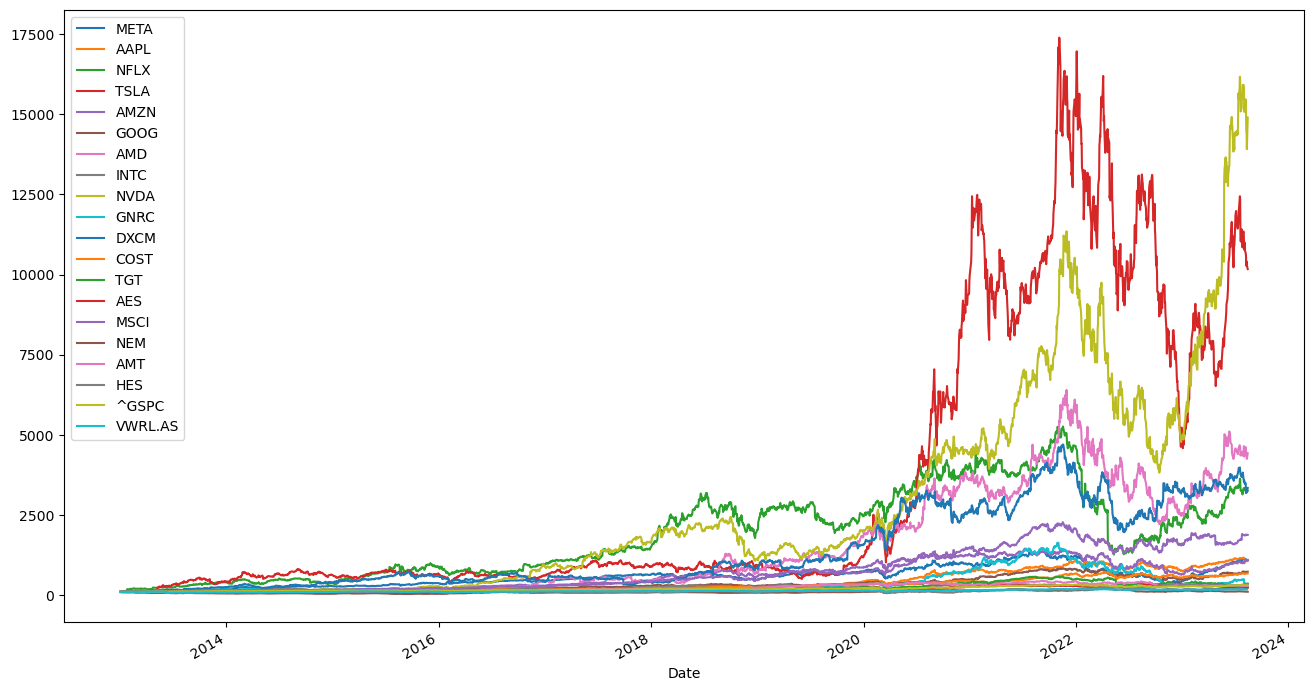

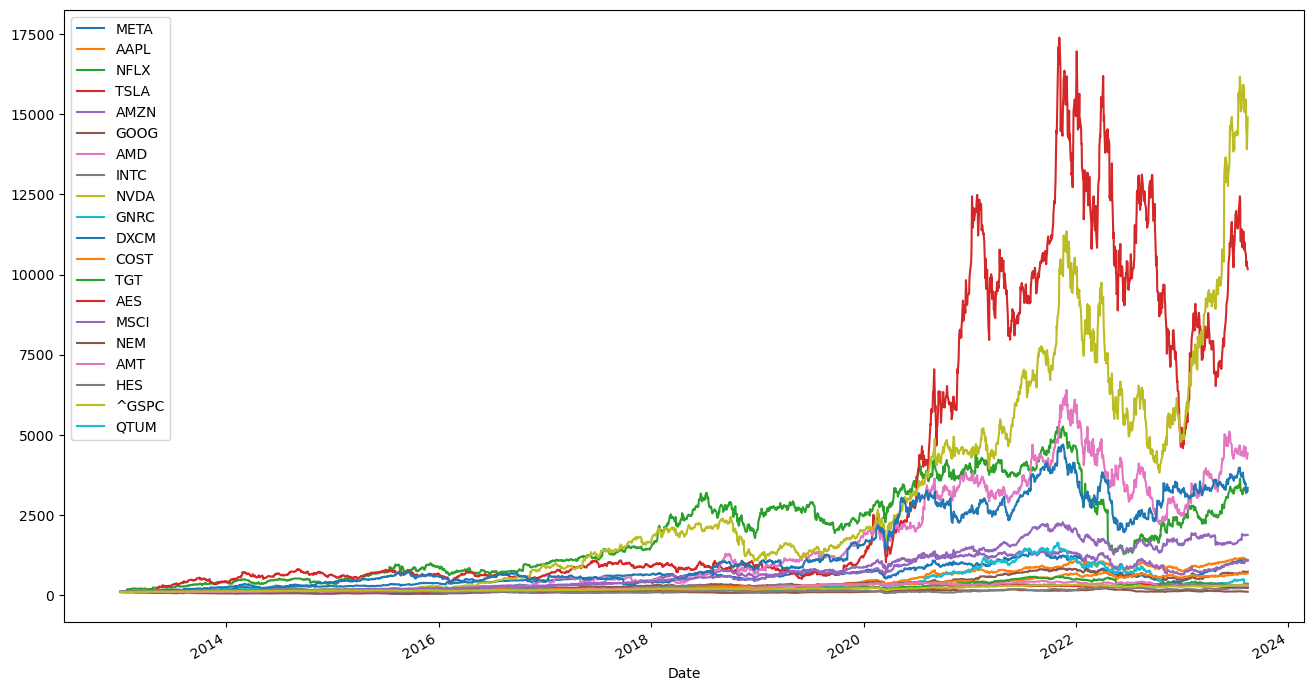

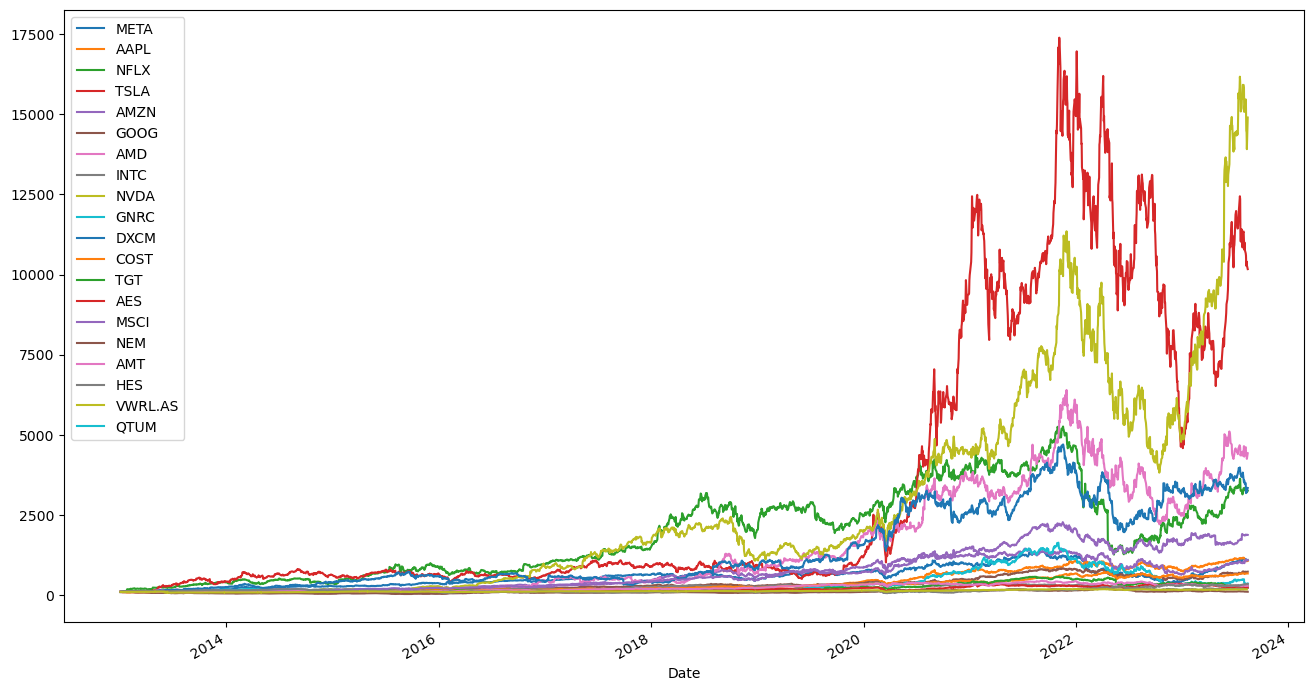

In [26]:
#If you want to plot
for dtfrm in list_of_dataframes[0:3]:
    #Plot growth of investments
    (dtfrm / dtfrm.iloc[0] * 100).plot(figsize=(16,9))

In [27]:
returns_list_of_dfs = []
mean_returns_list_of_dfs = []

for dtfrm in list_of_dataframes:
    rtrn = np.log(dtfrm/dtfrm.shift(1))
    returns_list_of_dfs.append(rtrn)
    mean_returns_list_of_dfs.append(rtrn.mean() * 252)
    

In [34]:
#Generate random weights equal total to 1
random_weights = np.random.random(max_assets)
random_weights /= np.sum(random_weights)
print('Weights: ', random_weights)
print('Total Weight: ', np.sum(random_weights))

Weights:  [0.03931314 0.00175245 0.07950748 0.05715841 0.04525551 0.07002247
 0.00407227 0.02172521 0.0859635  0.06118721 0.07818021 0.05648983
 0.08622727 0.03664468 0.04025832 0.04601792 0.08601533 0.05884914
 0.02326979 0.02208988]
Total Weight:  1.0


In [36]:
random_portfolio_return_list = []

for i in range(len(mean_returns_list_of_dfs)-1):
    random_portfolio_return_list.append(np.sum(weights[i] * mean_returns_list_of_dfs[i]) * 252 )

random_portfolio_return_list

[73.46324885565129,
 39.07386019131856,
 56.08683129235116,
 48.86512100735507,
 7.1170606529724925,
 83.67501659768018,
 32.91923947510497,
 31.02277288971296,
 16.515000824817502,
 80.03683456095015,
 43.77562130178401,
 13.414053281175214,
 76.99730735463089,
 71.54913966955598,
 65.88000224958316,
 26.788176506765883,
 94.08089357341902,
 57.87311389385246,
 71.18055250673507,
 4.4829821184242284]

In [37]:
random_portfolio_volatility_list = []

for i in range(len(returns_list_of_dfs)-1):
    random_portfolio_volatility_list.append(np.sqrt(np.dot(random_weights.T, np.dot(returns_list_of_dfs[i].cov() *252, random_weights))))

random_portfolio_volatility_list

[0.21490507591924068,
 0.21956761393014432,
 0.21786908631128327,
 0.21596552563972357,
 0.22204815975572675,
 0.2242155886585812,
 0.2188920799377775,
 0.22046276684272886,
 0.223284599842268,
 0.22432920501382847,
 0.21535752851709572,
 0.21397148669117183,
 0.20924789128497315,
 0.2114470833138054,
 0.2110315037119373,
 0.22043307414614097,
 0.21938876684157668,
 0.21413889766306693,
 0.21955720486946323,
 0.21961397848491768]

In [45]:
returns_of_portfolios = []
volatilites_of_portfolios = []
sharpe_ratios_of_portfolios = []
weights_of_portfolios = []

for i in range(len(list_of_dataframes)-1):
    print("Working on portfolio number ", i+1, " of ", len(list_of_dataframes))
    p_ret = []
    p_vol = []
    p_SR = []
    p_wt = []

    n_combinations = 10000

    print('Number of assets in portfolio: ', max_assets)
    print('Number of random combinations tried with these assets: ', n_combinations)

    for x in range(n_combinations):
        p_weights = np.random.random(max_assets)
        p_weights /= np.sum(p_weights)

        ret_1 = np.sum(p_weights * returns_list_of_dfs[i].mean()) * 252
        p_ret.append(ret_1)
        
        vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns_list_of_dfs[i].cov() * 252, p_weights)))
        #print("Vol_1: ", vol_1)
        p_vol.append(vol_1)

        SR_1 = (ret_1 - risk_free_rate)/vol_1
        p_SR.append(SR_1)
        
        p_wt.append(p_weights)

    returns_of_portfolios.append(np.array(p_ret))
    volatilites_of_portfolios.append(np.array(p_vol))
    sharpe_ratios_of_portfolios.append(np.array(p_SR))
    weights_of_portfolios.append(np.array(p_wt))
    print("Finished with portfolio number ", i+1, " of ", len(list_of_dataframes))
    print("-"*80)

    
display(returns_of_portfolios, volatilites_of_portfolios, sharpe_ratios_of_portfolios, weights_of_portfolios)

Working on portfolio number  0  of  21
Number of assets in portfolio:  20
Number of random combinations tried with these assets:  10000
Finished with portfolio number  0  of  21
--------------------------------------------------------------------------------
Working on portfolio number  1  of  21
Number of assets in portfolio:  20
Number of random combinations tried with these assets:  10000
Finished with portfolio number  1  of  21
--------------------------------------------------------------------------------
Working on portfolio number  2  of  21
Number of assets in portfolio:  20
Number of random combinations tried with these assets:  10000
Finished with portfolio number  2  of  21
--------------------------------------------------------------------------------
Working on portfolio number  3  of  21
Number of assets in portfolio:  20
Number of random combinations tried with these assets:  10000
Finished with portfolio number  3  of  21
---------------------------------------------

NameError: name 'volatilities_of_portfolios' is not defined

In [47]:
display(returns_of_portfolios, volatilites_of_portfolios, 
        #sharpe_ratios_of_portfolios,
         weights_of_portfolios)

[array([0.16957413, 0.2207219 , 0.19316269, ..., 0.19847839, 0.23069333,
        0.233912  ]),
 array([0.21218934, 0.22275807, 0.21531165, ..., 0.20610781, 0.21351268,
        0.19547317]),
 array([0.21592425, 0.21038484, 0.16814375, ..., 0.20101538, 0.22347471,
        0.19772567]),
 array([0.18946648, 0.18624412, 0.19310053, ..., 0.18148794, 0.20325666,
        0.21771447]),
 array([0.18163735, 0.18914727, 0.19136906, ..., 0.19563198, 0.19433516,
        0.23348058]),
 array([0.21546817, 0.17963937, 0.20790788, ..., 0.20093334, 0.18970522,
        0.25831726]),
 array([0.19471052, 0.18377605, 0.17805702, ..., 0.19305523, 0.19519575,
        0.19157262]),
 array([0.20229136, 0.19752975, 0.19424336, ..., 0.21652173, 0.17810546,
        0.19099822]),
 array([0.1801881 , 0.19535592, 0.20116283, ..., 0.19512754, 0.21084025,
        0.22180055]),
 array([0.19897078, 0.19747639, 0.19560234, ..., 0.17983403, 0.18638345,
        0.22538535]),
 array([0.19152204, 0.17292972, 0.17724434, ..., 0

[array([0.19460138, 0.22499558, 0.20928228, ..., 0.2281328 , 0.2383493 ,
        0.23274107]),
 array([0.2239487 , 0.22855825, 0.22810737, ..., 0.23170367, 0.22932774,
        0.2199033 ]),
 array([0.23085638, 0.22632378, 0.20272783, ..., 0.21752344, 0.24424886,
        0.22889295]),
 array([0.21490612, 0.20334346, 0.2241301 , ..., 0.20187674, 0.21608797,
        0.22249293]),
 array([0.21159008, 0.20985472, 0.22275115, ..., 0.21299324, 0.22349273,
        0.24161592]),
 array([0.23764409, 0.20906147, 0.22679227, ..., 0.23505553, 0.21313389,
        0.25010978]),
 array([0.21930054, 0.24027408, 0.20974686, ..., 0.229307  , 0.22111486,
        0.22401383]),
 array([0.21494941, 0.21880559, 0.22033257, ..., 0.22525867, 0.21342549,
        0.21843288]),
 array([0.21226905, 0.22226151, 0.22478843, ..., 0.22962495, 0.21603917,
        0.22813261]),
 array([0.22619433, 0.22390804, 0.22508121, ..., 0.21709337, 0.21936716,
        0.2481204 ]),
 array([0.21324016, 0.20791014, 0.20937138, ..., 0

[array([[0.04236277, 0.03611404, 0.00792955, ..., 0.00670874, 0.07200008,
         0.08194365],
        [0.07376538, 0.04705954, 0.07789958, ..., 0.08024936, 0.03823939,
         0.03273732],
        [0.02301645, 0.05722428, 0.06336163, ..., 0.09616014, 0.01946882,
         0.03363176],
        ...,
        [0.04615054, 0.08716395, 0.05792761, ..., 0.10697549, 0.06599554,
         0.00094235],
        [0.04660038, 0.01973983, 0.05202459, ..., 0.09401184, 0.00560998,
         0.01415654],
        [0.0671557 , 0.01115223, 0.07810404, ..., 0.07760795, 0.0039538 ,
         0.01925864]]),
 array([[0.07890914, 0.02297957, 0.07469081, ..., 0.03253662, 0.029479  ,
         0.05568084],
        [0.03864404, 0.01689212, 0.05354587, ..., 0.06632753, 0.06514848,
         0.03223468],
        [0.00012052, 0.05958796, 0.07607486, ..., 0.01841905, 0.02203363,
         0.05182007],
        ...,
        [0.05260564, 0.02353708, 0.00036072, ..., 0.05819141, 0.02344586,
         0.10049551],
        [0.0

In [50]:
#Plot efficient frontier
return_vol_list_of_dfs = []
for i in range(len(returns_of_portfolios)):
    return_vol_list_of_dfs.append(pd.DataFrame({'Return':returns_of_portfolios[i], 'Vol': volatilites_of_portfolios[i]}))

display(return_vol_list_of_dfs, len(return_vol_list_of_dfs))

[        Return       Vol
 0     0.169574  0.194601
 1     0.220722  0.224996
 2     0.193163  0.209282
 3     0.164507  0.199199
 4     0.202685  0.210278
 ...        ...       ...
 9995  0.231369  0.230744
 9996  0.212744  0.215879
 9997  0.198478  0.228133
 9998  0.230693  0.238349
 9999  0.233912  0.232741
 
 [10000 rows x 2 columns],
         Return       Vol
 0     0.212189  0.223949
 1     0.222758  0.228558
 2     0.215312  0.228107
 3     0.218711  0.231753
 4     0.233314  0.242543
 ...        ...       ...
 9995  0.216894  0.235538
 9996  0.187864  0.215356
 9997  0.206108  0.231704
 9998  0.213513  0.229328
 9999  0.195473  0.219903
 
 [10000 rows x 2 columns],
         Return       Vol
 0     0.215924  0.230856
 1     0.210385  0.226324
 2     0.168144  0.202728
 3     0.191246  0.207303
 4     0.225073  0.230228
 ...        ...       ...
 9995  0.222928  0.232150
 9996  0.171961  0.201665
 9997  0.201015  0.217523
 9998  0.223475  0.244249
 9999  0.197726  0.228893
 
 [10

20

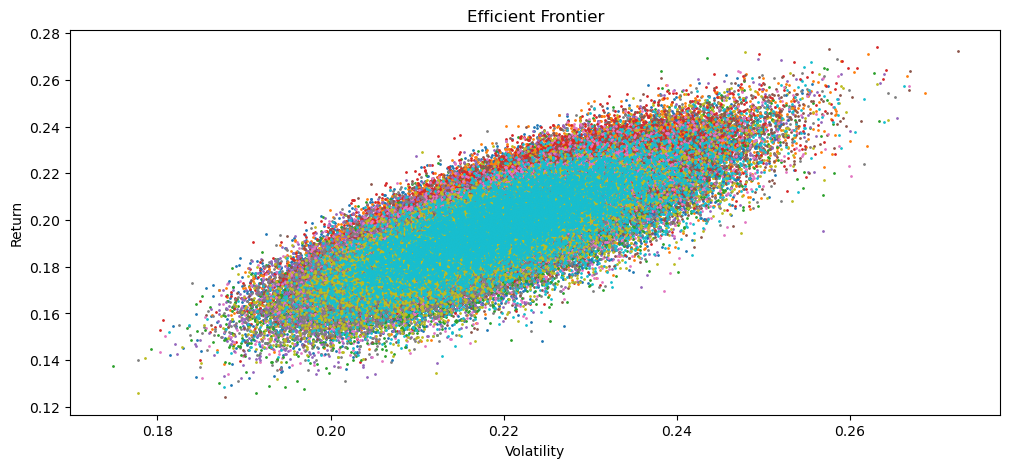

In [55]:
fig = plt.figure(figsize=(12,5))
for i in range(len(return_vol_list_of_dfs)):
    plt.scatter(x=return_vol_list_of_dfs[i]['Vol'], y=return_vol_list_of_dfs[i]['Return'], s=1)

plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [57]:
def find_max_sharpe(sharpe_ratios): #sharpe_ratios is a list of lists
    if not sharpe_ratios:
        return None
    
    largest_sharpe = sharpe_ratios[0][0]  # Initialize with the first element
    largest_element_row = 0
    largest_element_col = 0

    for row, sublist in enumerate(sharpe_ratios):
        for col, element in enumerate(sublist):
            if element > largest_sharpe:
                largest_sharpe = element
                largest_element_row = row
                largest_element_col = col

    return largest_sharpe, largest_element_row, largest_element_col

In [101]:
max_sharpe, max_sharpe_row, max_sharpe_col = find_max_sharpe(sharpe_ratios_fo_portfolios)
display(max_sharpe, max_sharpe_row, max_sharpe_col)

print("Assets in Optimal Portfolio: ", asset_combinations[:][max_sharpe_row])

i = 0
optimal_portfolio_weights = []

while i < max_assets:
    #print(asset_combinations[i][max_sharpe_row])
    print("Stock: %s: %2.2f" % (asset_combinations[max_sharpe_row][i], (weights_of_portfolios[i][max_sharpe_col][i] * 100))) #"Stock: %s: %2.2f" % (
    optimal_portfolio_weights.append(weights_of_portfolios[i][max_sharpe_col][i] * 100)
    i +=1

rounded_optimal_portfolio_weights = [round(x) for x in optimal_portfolio_weights]

print("\nVolatility: ", volatilites_of_portfolios[max_sharpe_row][max_sharpe_col])
print("\nReturn: ", returns_of_portfolios[max_sharpe_row][max_sharpe_col])
print("\nRecalculated Sharpe Ratio: ", 
    (returns_of_portfolios[max_sharpe_row][max_sharpe_col]-risk_free_rate)/volatilites_of_portfolios[max_sharpe_row][max_sharpe_col],
    "(this should match the maximum sharpe ratio value)")
print("Optimal portfolio weights: ", optimal_portfolio_weights)
print("Rounded portfolio weights: ", rounded_optimal_portfolio_weights)

1.0445015845520753

2

6909

Assets in Optimal Portfolio:  ('META', 'AAPL', 'NFLX', 'TSLA', 'AMZN', 'GOOG', 'AMD', 'INTC', 'NVDA', 'GNRC', 'DXCM', 'COST', 'TGT', 'AES', 'MSCI', 'NEM', 'AMT', 'HES', 'VWRL.AS', 'QTUM')
Stock: META: 2.34
Stock: AAPL: 5.37
Stock: NFLX: 4.14
Stock: TSLA: 3.32
Stock: AMZN: 7.55
Stock: GOOG: 2.88
Stock: AMD: 7.59
Stock: INTC: 3.72
Stock: NVDA: 0.11
Stock: GNRC: 1.96
Stock: DXCM: 1.14
Stock: COST: 8.45
Stock: TGT: 2.71
Stock: AES: 2.41
Stock: MSCI: 2.12
Stock: NEM: 3.11
Stock: AMT: 0.82
Stock: HES: 7.39
Stock: VWRL.AS: 3.56
Stock: QTUM: 7.45

Volatility:  0.23819884310334477

Return:  0.2637990690599148

Recalculated Sharpe Ratio:  1.0445015845520753 (this should match the maximum sharpe ratio value)
Optimal portfolio weights:  [2.3400194641276615, 5.367469330212639, 4.135031932969238, 3.3186990091038004, 7.548444327659057, 2.882469566574291, 7.587955816174015, 3.7207632480448707, 0.10998227099695396, 1.9622192952915531, 1.138185412219763, 8.44507983725041, 2.711710317400176, 2.4119278351

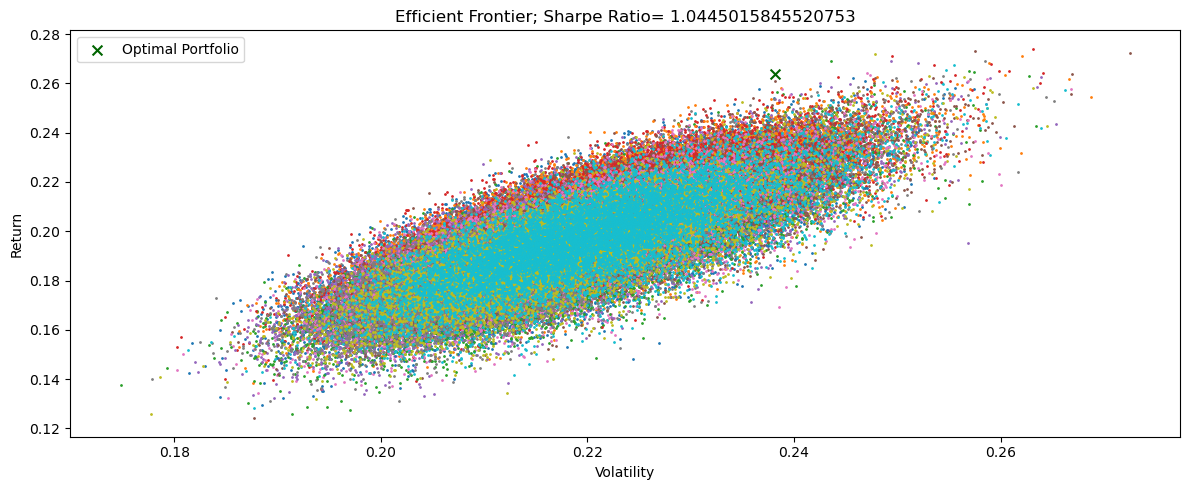

In [117]:
plt.rcParams["figure.autolayout"] = True

fig = plt.figure(figsize=(12,5))
for i in range(len(return_vol_list_of_dfs)):
    plt.scatter(x=return_vol_list_of_dfs[i]['Vol'], y=return_vol_list_of_dfs[i]['Return'], s=1)

plt.title('Efficient Frontier; Sharpe Ratio= '+str(max_sharpe))
plt.xlabel('Volatility')
plt.scatter(x=volatilites_of_portfolios[max_sharpe_row][max_sharpe_col],
            y=returns_of_portfolios[max_sharpe_row][max_sharpe_col], s=50, marker='x', color='darkgreen', label='Optimal Portfolio')
plt.ylabel('Return')
plt.legend()
plt.show()

In [ ]:
#Now we try to use pypfopt library